In [ ]:
"""
Jason Qin

Architecture and hyperparameter search

Adapted from: https://github.com/cs230-stanford/cs230-code-examples/blob/master/pytorch/vision/search_hyperparams.py
"""

In [2]:
import numpy as np
import argparse
import os
from subprocess import check_call
import sys
import re
import matplotlib.pyplot as plt

In [36]:
"""Test different architectures"""
PYTHON = sys.executable

# encoders = ['resnet50', 'resnet101']
# decoders = ['c1', 'upernet']
encoders = ['resnet50']
decoders = ['upernet']
# train = ['', '2']
train = ['3']
trainLists = ['train_list_10x_upsampling.odgt', 'train_list_100x_upsampling.odgt']

for encoder in encoders:
    for decoder in decoders:
        for t in train:
            cmd = ('CUDA_VISIBLE_DEVICES="0,1" python /home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/train{train}.py --num_gpus 2 --num_class 2 --root_data '
                   '/data2/yeom/ky_aneur/sah_png/train --list_train ~/cs230/code/cta-scripts/train_list_40x_upsampling.odgt --num_epoch 20 '
                   '--id {encoder}_{decoder}_train{train} --ckpt /data2/yeom/ky_aneur/results/ckpt/loss_weights/ --arch_encoder {encoder} --arch_decoder {decoder} --optim adam --epoch_iters 500').format(train=t, encoder=encoder, decoder=decoder)
            if 'upernet' in cmd:
                cmd = cmd + ' --segm_downsampling_rate 4 --padding_constant 32'
            output = '/home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/training_outputs/loss_weights/{}_{}_train{train}.txt'.format(encoder, decoder, train=t)
            print(cmd)
            print(output)
            with open(output, 'w') as f:
                check_call(cmd, shell=True, stdout=f)


for encoder in encoders:
    for decoder in decoders:
        for tl in trainLists:
            t = ''
            cmd = ('CUDA_VISIBLE_DEVICES="0,1" python /home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/train{train}.py --num_gpus 2 --num_class 2 --root_data '
                   '/data2/yeom/ky_aneur/sah_png/train --list_train ~/cs230/code/cta-scripts/{tl} --num_epoch 20 '
                   '--id {encoder}_{decoder}_train{train} --ckpt /data2/yeom/ky_aneur/results/ckpt/upsampling/ --arch_encoder {encoder} --arch_decoder {decoder} --optim adam --epoch_iters 500').format(train=t, tl=tl, encoder=encoder, decoder=decoder)
            if 'upernet' in cmd:
                cmd = cmd + ' --segm_downsampling_rate 4 --padding_constant 32'
            output = '/home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/training_outputs/upsampling/{}_{}_t{tl}.txt'.format(encoder, decoder, tl = tl)
            print(cmd)
            print(output)
            with open(output, 'w') as f:
                check_call(cmd, shell=True, stdout=f)

CUDA_VISIBLE_DEVICES="0,1" python /home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/train3.py --num_gpus 2 --num_class 2 --root_data /data2/yeom/ky_aneur/sah_png/train --list_train ~/cs230/code/cta-scripts/train_list_40x_upsampling.odgt --num_epoch 20 --id resnet50_upernet_train3 --ckpt /data2/yeom/ky_aneur/results/ckpt/loss_weights/ --arch_encoder resnet50 --arch_decoder upernet --optim adam --epoch_iters 500 --segm_downsampling_rate 4 --padding_constant 32
/home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/training_outputs/loss_weights/resnet50_upernet_train3.txt


KeyboardInterrupt: 

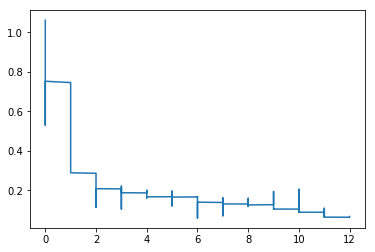

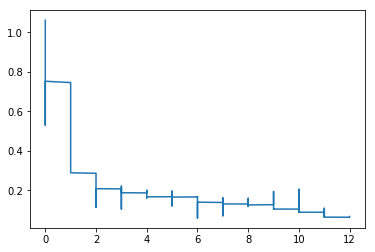

IOError: [Errno 2] No such file or directory: '/home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/training_outputs/arch/resnet50_upernet.txt'

In [33]:
"""Visualize architecture loss and IOU over time"""
encoders = ['resnet50', 'resnext101']
decoders = ['c1', 'ppm', 'upernet']

losses = []
ious = []
for encoder in encoders:
    for decoder in decoders:
        logFile = '/home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/training_outputs/arch/{}_{}.txt'.format(encoder, decoder)
        lines = [line.rstrip('\n') for line in open(logFile, 'r')]
        for line in lines:
            lossRe = re.compile('Loss: \d\.\d*')
            loss = lossRe.search(line)
            if loss is not None:
                loss = loss.group(0)
                loss = loss.split(' ')[1]
                losses.append(loss)
            
            iouRe = re.compile('IOU: \d\.\d*')
            iou = iouRe.search(line)
            if iou is not None:
                iou = iou.group(0)
                iou = iou.split(' ')[1]
                ious.append(iou)
            
        epochs = np.array(range(len(ious)))
        epochs = epochs / (740/20.)
        losses = np.array(losses).astype(np.float)
        ious = np.array(ious).astype(np.float)
        plt.plot(epochs, losses, label='Loss', marker='.', linestyle='')
        plt.show()
        plt.plot(epochs, ious, label='IOU', marker='.', linestyle='')
        plt.show()

In [ ]:
"""Evaluate different architectures"""
PYTHON = sys.executable

encoders = ['resnet50', 'resnext101']
decoders = ['c1', 'ppm', 'upernet']

for encoder in encoders:
    for decoder in decoders:
        resultDir = '/data2/yeom/ky_aneur/results/dev/{}_{}'.format(encoder, decoder)
        os.mkdir(resultDir)
        if 'upernet' in decoder:
            paddingConstant = 32
            segmDownsamplingRate = 4
        else:
            paddingConstant = 8
            segmDownsamplingRate = 8
        cmd = ('python eval.py --id {encoder}_{decoder}-{encoder}-{decoder}-ngpus2-batchSize4-imgMaxSize1000-paddingConst{paddingConstant}-segmDownsampleRate{segmDownsamplingRate}-LR_encoder0.02'
               '-LR_decoder0.02-epoch12 --list_val /home/ky_aneur/cs230/code/cta-scripts/dev_list.odgt --root_dataset /data2/yeom/ky_aneur/sah_png/dev/ '
               '--num_class 2 --ckpt /data2/yeom/ky_aneur/results/ckpt/loss_weights/ --visualize --result {resultDir} --suffix _epoch_12.pth').format(encoder=encoder, decoder=decoder, paddingConstant=paddingConstant, 
                                                                                                             segmDownsamplingRate = segmDownsamplingRate, resultDir = resultDir)
        output = '/home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/eval_outputs/arch/{}_{}.txt'.format(encoder, decoder)
        print(cmd)
        with open(output, 'w') as f:
            check_call(cmd, shell=True, stdout=f)

In [47]:
"""Test different hyperparameters"""
PYTHON = sys.executable

encoders = ['resnet50']
decoders = ['upernet']
learningRates = [2e-3, 2e-1]

for encoder in encoders:
    for decoder in decoders:
        for lr in learningRates:
            cmd = ('CUDA_VISIBLE_DEVICES="0,1" python /home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/train3.py --num_gpus 2 --num_class 2 --segm_downsampling_rate 4 --padding_constant 32 --root_data '
                   '/data2/yeom/ky_aneur/sah_png/train --lr_decoder {lr} --list_train /home/ky_aneur/cs230/code/cta-scripts/train_list_40x_upsampling.odgt --num_epoch 20 '
                   '--id {encoder}_{decoder}_{lr} --arch_encoder {encoder} --arch_decoder {decoder} --optim adam --epoch_iters 500 --ckpt /data2/yeom/ky_aneur/results/ckpt/learning_rate/').format(lr=lr, encoder=encoder, decoder=decoder)
            output = '/home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/training_outputs/learning_rate/{encoder}_{decoder}_{lr}.txt'.format(encoder=encoder, decoder=decoder, lr=lr)
            print(cmd)
            print(output)
            with open(output, 'w') as f:
                check_call(cmd, shell=True, stdout=f)


        

CUDA_VISIBLE_DEVICES="0,1" python /home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/train3.py --num_gpus 2 --num_class 2 --segm_downsampling_rate 4 --padding_constant 32 --root_data /data2/yeom/ky_aneur/sah_png/train --lr_decoder 0.002 --list_train /home/ky_aneur/cs230/code/cta-scripts/train_list_40x_upsampling.odgt --num_epoch 20 --id resnet50_upernet_0.002 --arch_encoder resnet50 --arch_decoder upernet --optim adam --epoch_iters 500 --ckpt /data2/yeom/ky_aneur/results/ckpt/learning_rate/
/home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/training_outputs/learning_rate/resnet50_upernet_0.002.txt
CUDA_VISIBLE_DEVICES="0,1" python /home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/train3.py --num_gpus 2 --num_class 2 --segm_downsampling_rate 4 --padding_constant 32 --root_data /data2/yeom/ky_aneur/sah_png/train --lr_decoder 0.2 --list_train /home/ky_aneur/cs230/code/cta-scripts/train_list_40x_upsampling.odgt --num_epoch 20 --id resnet50_upernet_0.2 -

In [ ]:
"""Evaluate different architectures"""
PYTHON = sys.executable

encoders = ['resnet50', 'resnext101']
decoders = ['c1', 'ppm', 'upernet']

for encoder in encoders:
    for decoder in decoders:
        resultDir = '/data2/yeom/ky_aneur/results/dev/{}_{}'.format(encoder, decoder)
        os.mkdir(resultDir)
        if 'upernet' in decoder:
            paddingConstant = 32
            segmDownsamplingRate = 4
        else:
            paddingConstant = 8
            segmDownsamplingRate = 8
        cmd = ('python eval.py --id {encoder}_{decoder}-{encoder}-{decoder}-ngpus2-batchSize4-imgMaxSize1000-paddingConst{paddingConstant}-segmDownsampleRate{segmDownsamplingRate}-LR_encoder0.02'
               '-LR_decoder0.02-epoch12 --list_val /home/ky_aneur/cs230/code/cta-scripts/dev_list.odgt --root_dataset /data2/yeom/ky_aneur/sah_png/dev/ '
               '--num_class 2 --ckpt ./ckpt --visualize --result {resultDir} --suffix _epoch_12.pth').format(encoder=encoder, decoder=decoder, paddingConstant=paddingConstant, 
                                                                                                             segmDownsamplingRate = segmDownsamplingRate, resultDir = resultDir)
        output = '/home/ky_aneur/cs230/code/resnet/semantic-segmentation-pytorch/eval_outputs/arch/{}_{}.txt'.format(encoder, decoder)
        print(cmd)
        with open(output, 'w') as f:
            check_call(cmd, shell=True, stdout=f)